# L9a: Introduction to Hopfield Networks
In this lecture, we will introduce Hopfield Networks, a type of recurrent neural network that is used for associative memory. We will discuss the architecture of Hopfield Networks, their dynamics, and their applications in various fields. The key concepts in this lecture are:
* __A Hopfield network__ is a type of recurrent neural network designed to function as a content-addressable memory system, capable of storing and retrieving patterns through associative recall. Introduced in [1982 by John Hopfield](https://pmc.ncbi.nlm.nih.gov/articles/PMC346238/) and recently awared [the Nobel Prize in Physics in 2025](https://news.cornell.edu/stories/2024/10/john-hopfield-phd-58-wins-nobel-prize-physics), it consists of a single layer of interconnected neurons with bidirectional, symmetric connections (excluding self-connections). 
* Each neuron in a Hopfield network operates in a binary $s\in\left\{0,1\right\}$ or biploar $s\in\left\{-1,1\right\}$ state and updates its state based on weighted inputs from others until the network stabilizes to an energy minimum, representing a stored memory.
* __Hopfield Networks__ have a few interesting features. First, they use Hebbian learning: Connection weights are adjusted during training to encode patterns via correlation-based rules, not a seacrh. Second, they are content-addressable: The network can retrieve stored patterns even if the input is noisy or incomplete. Third, they are energy-based: The network's dynamics are governed by an energy function, which decreases as the network converges to a stable state.

## What is a Hopfield network?
A [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) is a fully connected undirected graph 
consisting of $N$ nodes, where each node in the graph has a state $s = \pm{1}$; each node is connected to every other node, but not to itself, i.e., the network has no self-loops. The weights of the connection between node $i$ and $j$, denoted as $w_{ij}\in\mathbf{W}$ are learned using [a Hebbian learning rule](https://en.wikipedia.org/wiki/Hebbian_theory). 
* _What is Hebbian learning?_ The [Hebbian learning rule](https://en.wikipedia.org/wiki/Hebbian_theory), proposed by [Donald Hebb in 1949](https://en.wikipedia.org/wiki/Donald_O._Hebb), says that synaptic connections between neurons are strengthened when they activate (fire) simultaneously, forming the biological basis for __associative learning__. This "fire together, wire together" principle underpins unsupervised learning in neural networks, linking co-active nodes to enable pattern storage and adaptation.
* _How is this different than other learning approaches?_ Unlike the previous examples of learning, e.g., logistic regression, or any of the online learning approaches that we looked at previously, the parameters (weights) in a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) are completely specified by the memories we want to encode. Thus, we do not need to search for the weights, or learn them by experimentation with the world. Instead, we can directly compute the weights from the memories we want to encode.

### Encoding memories into a Hopfield network
Suppose we wish our network to memorize $m$-images, where each image is an $n\times{n}$ collection of black and white pixels represented as a vector $\mathbf{s}_{i}\in\left\{-1,1\right\}\in{R}^{n^2}$. We encode the image using the following rule: if the pixel is white, we set the value to $1$, and if the pixel is black, we set the value to $-1$. Then the weights that encode these $m$-images are given by:
$$
\begin{equation*}
\mathbf{W} = \frac{1}{m}\cdot\sum_{i=1}^{m}\mathbf{s}_{i}\otimes\mathbf{s}_{i}^{\top}
\end{equation*}
$$
where $\mathbf{s}_{i}$ denotes the state (pixels) of the image we want to memorize, and $\otimes$ denotes the outer product. Thus, the weights are the average of all of our memories!

* __How big is $m$?__: The maximum theoretical storage limit $K_{\text{max}}$ (the maximum number of possible images that can be stored) of a Hopfield network, using the standard Hebbian learning rule, is approximately $K_{max}\sim{0.138}{N}$, where $N$ is the number of neurons in the network. Thus, the network can reliably store about 14\% of its size in patterns before retrieval errors become significant due to interference between stored patterns.

Suppose we've encoded $m$-images, and we want to retrieve one of them.  This seems a little magical. How does that work? 

### Memory retrieval
The basic idea of [a Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) is that each memory is encoded as a _local minimum_ of a global energy function. Thus, during memory retrival, when we supply a random state vector $\hat{\mathbf{s}}$, we will recover the _closet_ memory encooded in the network to where we start, assuming a greedy descent, where we only take downhill energy steps.
The overall energy of the network is given by:
$$
\begin{equation*}
E(\mathbf{s}) = -\frac{1}{2}\cdot\sum_{ij}w_{ij}s_{i}s_{j} - \sum_{i}b_{i}s_{i}
\end{equation*}
$$
where $w_{ij}\in\mathbf{W}$ are the weights of the network, and $b_{i}$ is a bias term. The bias term is used to control the activation of the neurons in the network. The bias term is usually set to zero, but it can be used to control the activation threshold of the neurons in the network.

#### Algorithm
__Initialize__: Compute the weights $w_{ij}\in\mathbf{W}$ using the Hebbian learning rule, as described above.  Initialize the network with a random state $\mathbf{s}$. Then, use the following algorithm to retrieve a memory:

While __not__ converged:
1. Compute the energy of the network in the current state $\mathbf{s}$ before the update: $E(\mathbf{s})$.
1. Choose a random node $i$ and compute a new (potential) state $s_{i}^{\prime}$ using the update rule: $s_{i}^{\prime} \leftarrow \sigma\left(\sum_{j}w_{ij}s_{j}-b_{i}\right)$, where $\sigma$ is [the `sign(...)` function](https://docs.julialang.org/en/v1/base/math/#Base.sign) and $b_{i}$ is a bias (threshold) parameter.  
2. Compute the energy of the network after the (potential) update: $E(\mathbf{s}^{\prime})$. If $E(\mathbf{s}^{\prime}) < E(\mathbf{s})$, then update the state of the network: $\mathbf{s} \leftarrow \mathbf{s}^{\prime}$.
3. Check for convergence: If the state of the network does not change between updates i.e., $\lVert \mathbf{s}^{\prime} - \mathbf{s} \rVert \leq\epsilon$, then the network has converged to a memory. Alternatively, check if the energy of the network has converged, i.e., $\lVert E(\mathbf{s}^{\prime}) - E(\mathbf{s}) \rVert \leq\epsilon$.
4. Continue until convergence.

## Example: Learning a single image pattern
In this example, we'll use a Hopfield network to learn a single image pattern from [the MINST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database). The goal is to train the network to recognize a digit, e.g., "3" or "5", etc and then retrieve it from a noisy input.

First, let's set up the computational environment by importing the necessary libraries (and codes) by including the `Include.jl` file.

In [ ]:
include("Include.jl"); # load a bunch of libs, including the ones we need to work with images

In [1]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

### Load the training data
Load a training image dataset that we'll encoded into the Hopfield network. We'll save training data in the `training_image_dataset` variable.
* _What's in the training dataset_? The `training_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` i.e., whether the image corresponds to `0,....,9`. However, the label is encoded as a `OneHotVector` (see below).
* _Hmmm. That's strange_. The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of _weird features_. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

However, before we load the training data, let's set some constants that we use below. See the comment next to the constant for a description of what it is, its permissible values, units, etc.

In [ ]:
number_of_training_examples = 30; # how many training examples of each number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
number_of_steps = 5000; # how many flips do we do? 

`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}`, and then we'll convert these to a vector format below.

In [4]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    for i ∈ number_digit_array
        
        # create a set for this digit -
        image_digit_array = Array{Gray{N0f8},3}(undef, 28, 28, number_of_training_examples);
        files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
        imagecount = 1;
        for fileindex ∈ 1:number_of_training_examples
            filename = files[fileindex];
            ext = file_extension(filename)
            if (ext == "jpg")
                image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
                imagecount += 1
            end
        end
    
        # capture -
        training_image_dictionary[i] = image_digit_array
    end
    training_image_dictionary
end;

Next, we take the images in array format and vectorize them. 
* _What do we mean, vectorize_? Each $N\times{N}$ image array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/) which has different memory constraints.

In [5]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, 28*28);
            linearindex = 1;
            for row ∈ 1:28
                for col ∈ 1:28
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

### Weights
Now let's setup the weights (and bias terms) for the model from images encoded in the the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}`. A [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) has two sets of parameters, the weight matrix $\mathbf{W}$ and the gain vector $\mathbf{b}$.

A [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) uses a special [Hebbian learning rule](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2010.01472), where the weights $w_{ij}\in\mathbf{W}$ are _encoded_ by the image (or memory) the network is trying to learn. The weights $\mathbf{W}$ are given by (for a single image):
$$
\begin{equation*}
\mathbf{W} = \hat{\mathbf{s}}\otimes\hat{\mathbf{s}}^{T}
\end{equation*}
$$
where $\hat{\mathbf{s}}$ denotes the pixel pattern of the image that we want to learn, and $\otimes$ denotes the _outer product_, i.e., $w_{ij} = \hat{s}_{i}\hat{s}_{j}$. To get the weight matrix, let's select an image and compute the state vector $\hat{\mathbf{s}}$, and then compute the inner product.
* The state vector $\mathbf{s}$ have values of $\pm{1}$, so a pixel value of `0` will get mapped to $s=$ `-1`, otherwise it will be $s=$ `1`.

In [6]:
ŝ,example_image_index = let

    example_image_index = 156; # select an image from the training dataset 
    ŝ = Array{Int64,1}(undef, number_of_pixels);
    image = training_image_dataset[example_image_index][1];

    for i ∈ 1:number_of_pixels
        pixel = image[i] |> round;
        if pixel == 0.0
            ŝ[i] = -1;
        else
            ŝ[i] = 1;
        end
    end    
    ŝ,example_image_index
end;

Let's use [the `decode(...)` function](src/Compute.jl) to convert the state vector $\mathbf{s}$ back into an image that we can see:

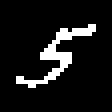

In [8]:
decode(ŝ) |> img -> Gray.(img)

Next, let's compute the weight matrix $\mathbf{W}$:

In [9]:
W = ⊗(ŝ,ŝ) .|> Int32

784×784 Matrix{Int32}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 ⋮              ⋮              ⋮        ⋱           ⋮              ⋮        
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1    

Finally, we can compute the bias vector $\mathbf{b}$. Elements of the bias vector $\mathbf{b}$ can be any value between `-1` and `1`. So let's select a random $\mathbf{b}$:

In [10]:
b = let

    b = Array{Float32,1}(undef,number_of_pixels); # initialize some space
    L = -1.0; # lower bound
    U = 1.0; # upper bound

    # main
    for i ∈ 1:number_of_pixels
       f = rand();
        b[i] = f*U+(1-f)*L;
    end

    b
end;

Can we recover the selected image?
In this task, we'll test whether or not we can recover the test image, starting from a random state vector $\mathbf{s}_{\circ}$, by iterating the state of the network. Let's begin by initializing a random state vector $\mathbf{s}_{\circ}$.

In [11]:
sₒ = let

    sₒ = Array{Int32,1}(undef, number_of_pixels); # initialize some space
    θ = 0.60;

    for i ∈ 1:number_of_pixels
        if (rand() ≤ θ)
            sₒ[i] = -1;
        else
            sₒ[i] = 1;
        end
    end
    sₒ;
end;

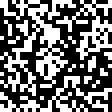

In [12]:
decode(sₒ) |> img -> Gray.(img)

Now that we have a starting memory encoded in the state vector $\mathbf{s}_{\circ}$, let's see if we can recover the original image.
* __What do we expect to happen?__ Starting from the initial random configuration, we'll randomly select pixels and flip them (or at least evaluate the activation function). We'll store a copy of the (potentially) flipped state and compute the energy for the (potentially) flipped state. We expect the energy to decrease as we converge toward the correct image.

In [13]:
frames, energydictionary = let

    # initialize -
    frames = Dict{Int64, Array{Int32,1}}();
    energydictionary = Dict{Int64, Float32}();

    # setup -
    frames[0] = copy(sₒ); # copy the initial random state
    energydictionary[0] = energy(sₒ,W, b);

    s = copy(sₒ);
    for i ∈ 1:number_of_steps

        j = rand(1:number_of_pixels); # select a random pixel
        s[j] = sign(transpose(W[j,:])*s - b[j]);

        frames[i] = copy(s); # save a copy
        energydictionary[i] = energy(s,W, b);
    end
    

    frames, energydictionary
end;

First, does the energy decrease as we flip the states in the network? Let's plot the values in the `energydictionary::Dict{Int64, Float32}` and see.

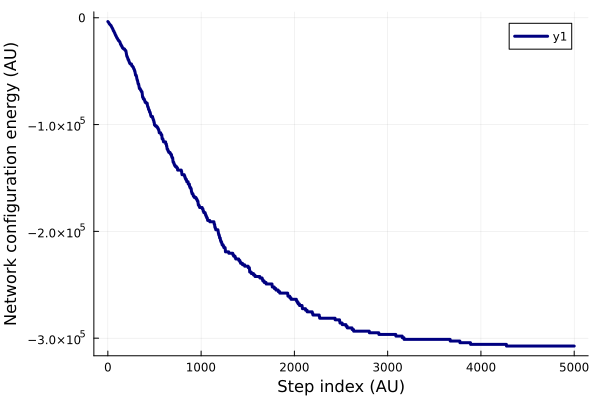

In [14]:
let
    plot(energydictionary, lw=3,c=:navy)
    xlabel!("Step index (AU)", fontsize=18)
    ylabel!("Network configuration energy (AU)", fontsize=18)
end

The energy is decreasing, but do we see the correct image?
* __Interesting__: Depending upon where we start, we should recover the original image or the anti-image of the original image. Why does the network store the anti-image?

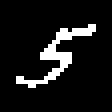

In [15]:
let
    image_index_to_view = 5000;
    s = frames[image_index_to_view];
    decode(s) |> image -> Gray.(image)
end

## Lab
In `L9d`, we will encode multiple memories, see how many images we can encode into a Hopfield network, and think about how to encode continuous values (not just binary values) into a Hopfield network.

# Today?
That's a wrap! What are some of the interesting things we discussed today?